In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json

In [55]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [56]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

In [57]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

'<|endoftext|>'

In [58]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [59]:
class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image']
        caption = sample['caption']
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']
        caption = f"{caption}<|endoftext|>"
        input_ids = tokenizer(
            caption,
            truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]
        return image,input_ids,labels

In [60]:
from pathlib import Path
import pandas as pd

# Define paths
image_dir_path = Path('D:/PhD file/image caption/PhD datasets/Total_cancer_image_caption/images/')
caption_file_path = Path('D:/PhD file/image caption/PhD datasets/Total_cancer_image_caption/medical_image_captions.csv')

# Read caption file (assumed to be in CSV format)
df = pd.read_csv(caption_file_path)

# Ensure the dataframe contains 'image_id', 'caption_id', and 'caption'
# Assuming the dataset contains 'image_id', 'caption_id', 'caption' columns
df['image'] = df['image_id'].apply(
    lambda x: image_dir_path / f"{x}"  # Directly use image_id as the filename
)

# Get the number of unique image_ids
unique_image_ids_count = df['image_id'].nunique()

# Check if the number of unique image_ids is greater than or equal to 530
sample_size = min(530, unique_image_ids_count)

# Sample 530 unique image_ids
sampled_image_ids = df['image_id'].drop_duplicates().sample(sample_size, random_state=42)

# Filter the original dataframe to include only the captions for the sampled image_ids
sampled_df = df[df['image_id'].isin(sampled_image_ids)]

# Reset index after sampling
sampled_df = sampled_df.reset_index(drop=True)

# Display the first few rows of the sampled dataframe
print(sampled_df.head())

# Verify the number of captions per sampled image
captions_per_image = sampled_df.groupby('image_id').size()
print(captions_per_image.head())  # Display first few image_id caption counts


     image_id  caption_id                                            caption  \
0  100522.jpg           0  There is right large heterogeneously enhancing...   
1  100522.jpg           1  There is right superior sulcus mass lesion wit...   
2  100522.jpg           2  There is middle lobe bronchiectasis and wall t...   
3  100522.jpg           3  Conclusion:  Spinal canal narrowing as describ...   
4  100522.jpg           4  Conclusion:  Known cervical ca with multiple b...   

                                               image  
0  D:\PhD file\image caption\PhD datasets\Total_c...  
1  D:\PhD file\image caption\PhD datasets\Total_c...  
2  D:\PhD file\image caption\PhD datasets\Total_c...  
3  D:\PhD file\image caption\PhD datasets\Total_c...  
4  D:\PhD file\image caption\PhD datasets\Total_c...  
image_id
100522.jpg      5
100522a.jpg     5
101697.jpg     10
10170.jpg       6
10170c.jpg      6
dtype: int64


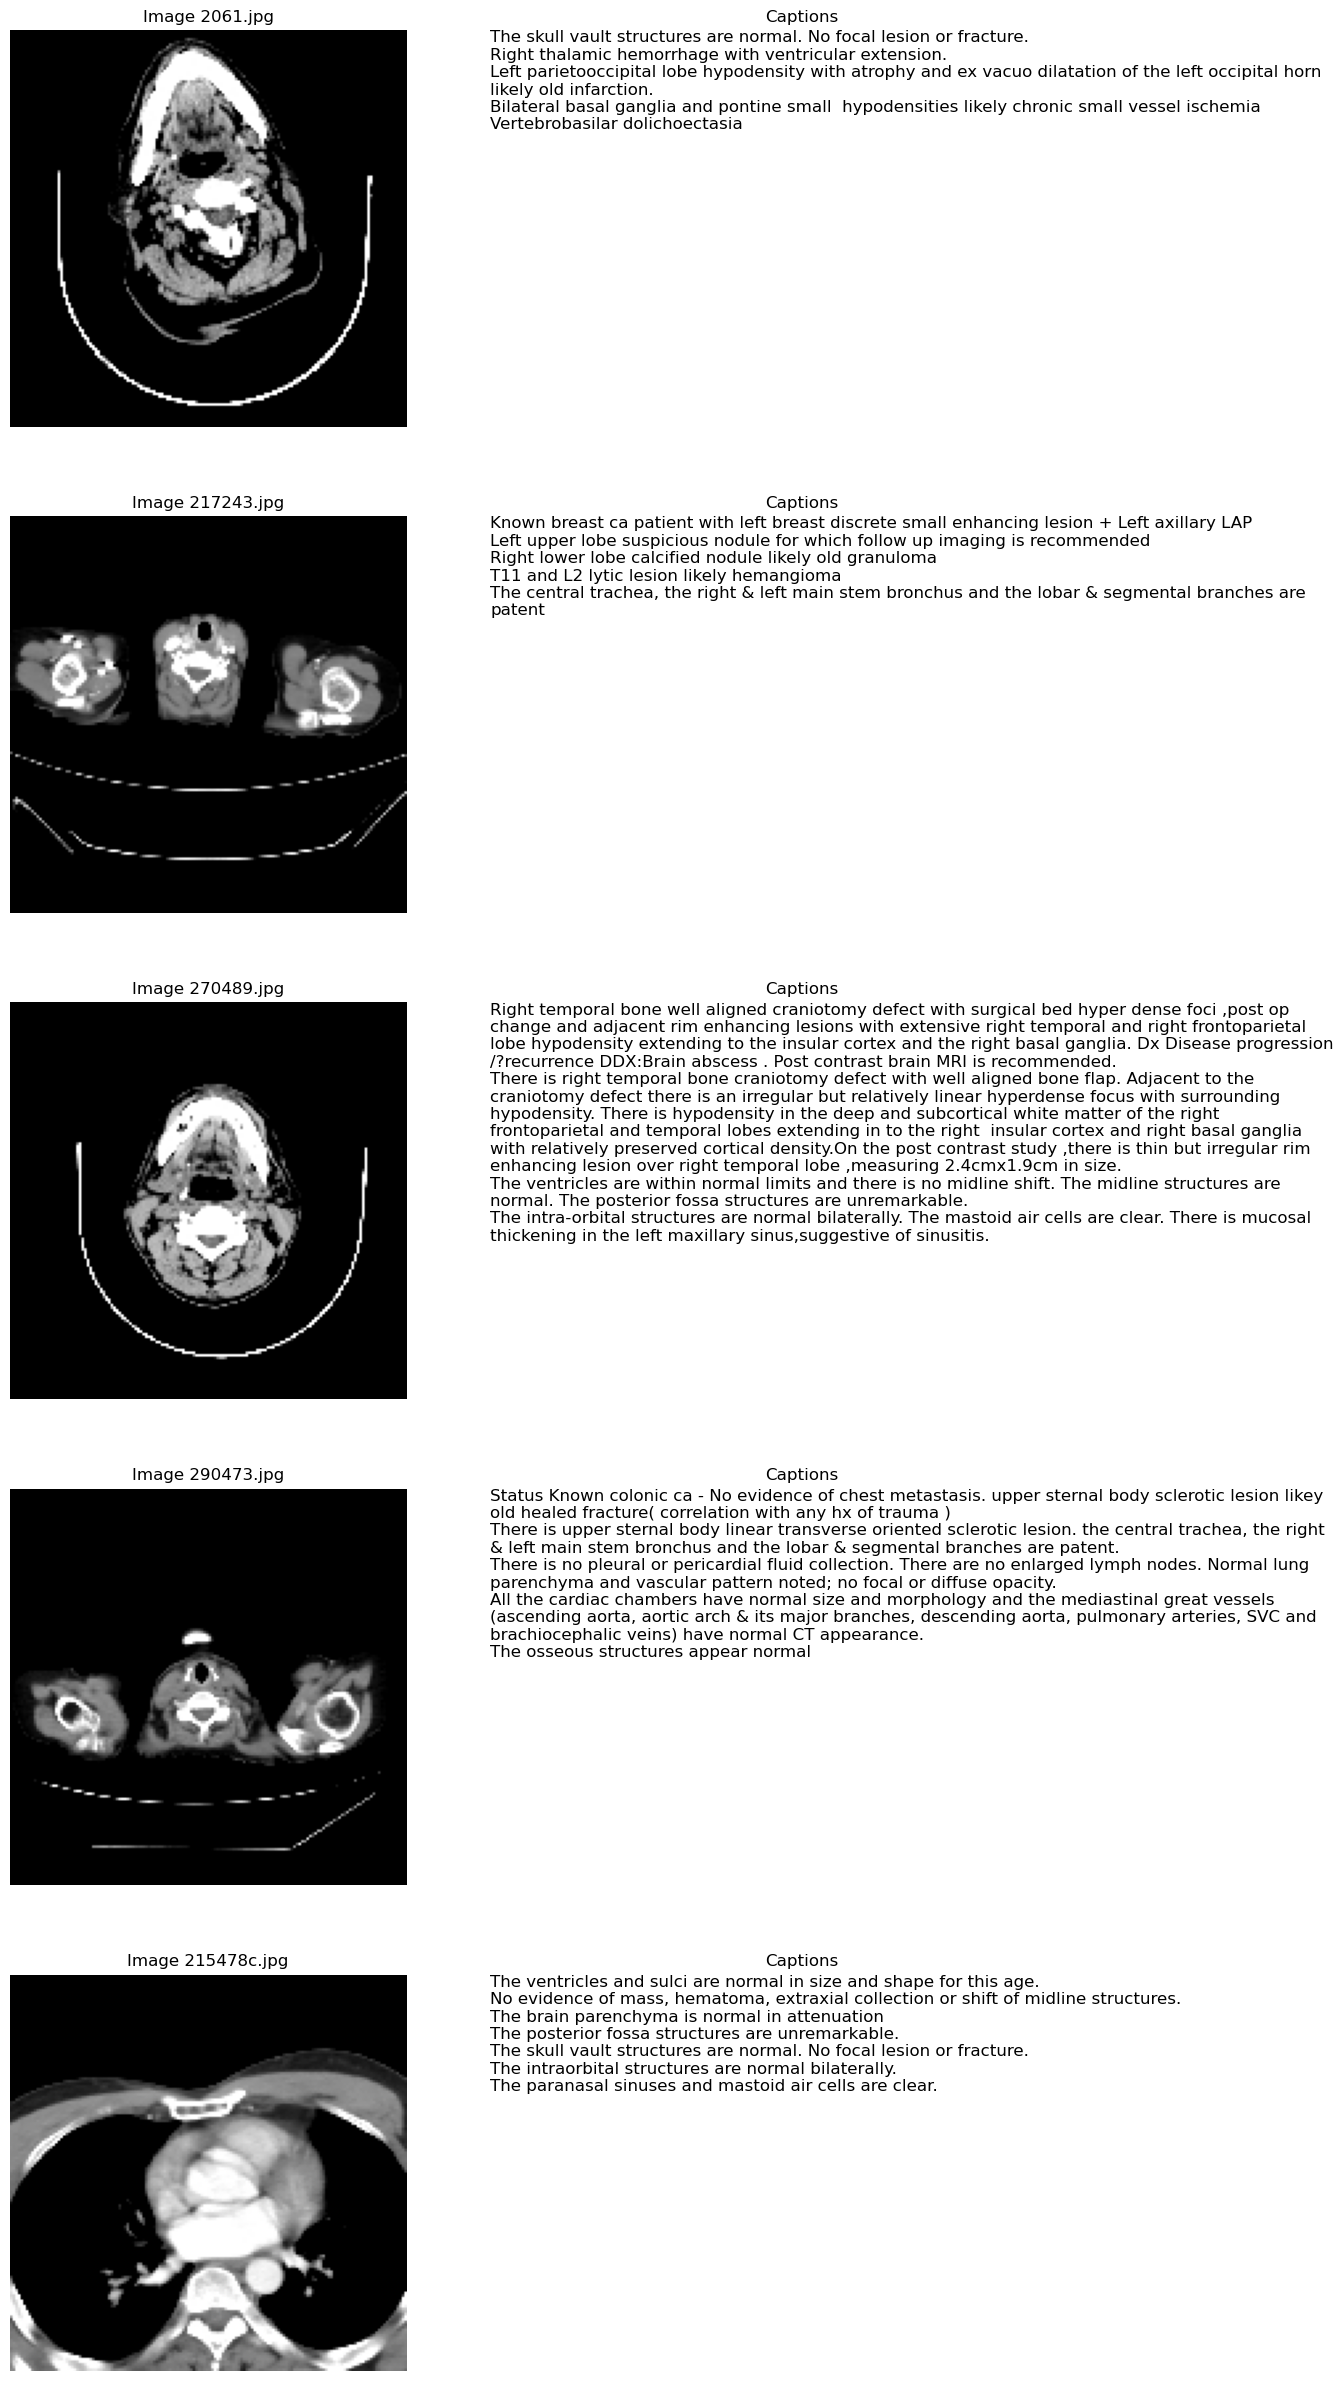

In [61]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Randomly sample 5 unique images from the captions_per_image series
sampled_images = random.sample(list(captions_per_image.index), 5)

# Set up the plot
fig, axs = plt.subplots(5, 2, figsize=(15, 25))

for i, image_id in enumerate(sampled_images):
    # Select the image and its captions
    image_row = df[df['image_id'] == image_id]  # Get all captions for the current image
    image_path = image_row.iloc[0]['image']  # Assuming 'image' column has the file path
    captions = image_row['caption'].tolist()  # List of captions for the image

    # Load the image
    image = Image.open(image_path)

    # Display the image on the left
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')  # Hide axis
    axs[i, 0].set_title(f"Image {image_id}", fontsize=12)

    # Display captions on the right (left-aligned) with a larger font size
    caption_text = '\n'.join(captions)  # Join multiple captions with new lines
    axs[i, 1].text(0, 1, caption_text, ha='left', va='top', fontsize=12, wrap=True)  # Increased font size
    axs[i, 1].axis('off')  # Hide axis
    axs[i, 1].set_title("Captions", fontsize=12)

# Adjust layout to ensure there is enough space for all captions
plt.tight_layout(pad=5.0)  # Increase padding between the image and caption
plt.show()


In [62]:
train_df, val_df = train_test_split(captions_per_image,test_size=0.1)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
print(len(train_df),len(val_df))

470 53


In [63]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

In [64]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

In [65]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform if transform else transforms.ToTensor()  # Default transformation

    def __getitem__(self, idx):
        # Get the row corresponding to the index
        sample = self.df.iloc[idx]
        image_path = sample['image']  # Path to the image
        captions = sample['caption']  # List of captions for this image
        
        # Load the image
        image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB mode
        
        # Apply transformation to the image (e.g., convert to tensor)
        if self.transform:
            image = self.transform(image)

        return image, captions  # Return the image and its captions

    def __len__(self):
        return len(self.df)


In [66]:
def collate_fn(batch):
    images, captions = zip(*batch)  # Unzip the batch into images and captions

    # Stack the images into a batch (assuming images are tensors after transformation)
    images = torch.stack(images, 0)  # Stack images into a tensor

    # Pad the captions if necessary (e.g., using a padding token or truncation)
    max_caption_length = max(len(c) for c in captions)  # Find the max caption length
    padded_captions = []

    for caption_list in captions:
        # Padding captions to ensure equal length for the batch
        padded_caption = caption_list + ['<PAD>'] * (max_caption_length - len(caption_list))
        padded_captions.append(padded_caption)

    return images, padded_captions


In [67]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        # Define a transform pipeline with resizing
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to a fixed size
            transforms.ToTensor(),  # Convert to tensor
        ])

    def __getitem__(self, idx):
        # Get the row corresponding to the index
        sample = self.df.iloc[idx]
        image_path = sample['image']  # Path to the image
        captions = sample['caption']  # List of captions for this image
        
        # Ensure captions are in a list format
        if isinstance(captions, str):
            captions = captions.split(',')  # Split by comma if stored as a string

        # Convert each caption into a list of words (if not already)
        captions = [caption.split() for caption in captions]

        # Load the image
        image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB mode
        
        # Apply transformation to the image (e.g., resize and convert to tensor)
        if self.transform:
            image = self.transform(image)

        return image, captions  # Return the image and its captions

    def __len__(self):
        return len(self.df)

import torch

def collate_fn(batch):
    images, captions = zip(*batch)  # Unzip the batch into images and captions
    
    # Stack the images into a batch (assuming images are tensors after transformation)
    images = torch.stack(images, 0)  # Stack images into a tensor
    
    # Find the max caption length in the batch (longest caption)
    max_caption_length = max(len(word) for caption_list in captions for caption in caption_list for word in caption)
    
    # Find the max number of captions in the batch
    max_captions = max(len(caption_list) for caption_list in captions)
    
    padded_captions = []
    
    for caption_list in captions:
        # Pad each caption in the list to max_caption_length
        padded_caption_list = [caption + ['<PAD>'] * (max_caption_length - len(caption)) for caption in caption_list]
        
        # If an image has fewer captions, pad the list of captions to max_captions
        while len(padded_caption_list) < max_captions:
            padded_caption_list.append(['<PAD>'] * max_caption_length)  # Add empty caption
        
        padded_captions.append(padded_caption_list)
    
    return images, padded_captions


# Assuming 'df' is your DataFrame with image paths and captions
train_ds = CustomDataset(df, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 150x150
    transforms.ToTensor(),  # Convert to tensor
]))

# DataLoader with batching and custom collate_fn
dl = DataLoader(train_ds, shuffle=True, batch_size=2, collate_fn=collate_fn)

# Fetch a batch
images, captions = next(iter(dl))

# Print first image caption and label (to check)
print(captions[0])  # Print first image's padded captions
# print(images[0])

[['There', 'is', 'no', 'evidence', 'for', 'ascites.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']]


In [68]:
# Set a padding token if not already defined
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})  # Add a new pad token


In [69]:
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use `eos_token` as the pad token


In [70]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2TokenizerFast

# Initialize tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

# Set a padding token if not already defined
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]', 'unk_token': '[unk]'})

# Example custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, captions):
        self.images = images
        self.captions = captions

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.captions[idx]

# DataLoader collate function
def collate_fn(batch):
    images, captions = zip(*batch)  # Unzip the batch into images and captions

    # Stack images into a tensor
    images = torch.stack(images, 0)

    # Tokenize and pad captions
    tokenized_captions = tokenizer(
        list(captions),  # Flatten caption list
        padding="max_length",  # Pad to the maximum length
        truncation=True,
        max_length=20,  # Define a maximum length for captions
        return_tensors="pt",
    )

    # Prepare input_ids and labels
    input_ids = tokenized_captions["input_ids"]
    labels = input_ids.clone()

    # Replace padding token ID with -100 in labels to ignore during loss calculation
    labels[labels == tokenizer.pad_token_id] = -100

    return images, input_ids, labels

# Example dataset and DataLoader
dummy_images = [torch.rand(3, 224, 224) for _ in range(10)]  # 10 random images (3x224x224)
dummy_captions = ["A sample caption." for _ in range(10)]  # 10 captions

# Create dataset
dataset = CustomDataset(dummy_images, dummy_captions)

# Create DataLoader
dl = DataLoader(dataset, batch_size=2, collate_fn=collate_fn, num_workers=0)

# Test with a batch
batch = next(iter(dl))
images, input_ids, labels = batch

# Print results
print("Images shape:", images.shape)  # Should be (batch_size, 3, 224, 224)
print("Input IDs shape:", input_ids.shape)  # Should be (batch_size, max_length)
print("Labels shape:", labels.shape)  # Should be (batch_size, max_length)


Images shape: torch.Size([2, 3, 224, 224])
Input IDs shape: torch.Size([2, 20])
Labels shape: torch.Size([2, 20])


In [71]:
from custom_dataset import CustomDataset

In [72]:
from transformers import GPT2TokenizerFast
from torch.utils.data import DataLoader
import torch

# Assuming `train_ds` is already defined as your dataset

# Initialize tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

# Set a padding token if not already defined
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# DataLoader collate function
def collate_fn(batch):
    images, captions = zip(*batch)  # Unzip the batch into images and captions

    # Stack images into a tensor
    images = torch.stack(images, 0)

    # Tokenize and pad captions
    tokenized_captions = [
        tokenizer(
            caption,
            padding="max_length",  # Pad to the maximum length
            truncation=True,
            max_length=20,  # Define a maximum length for captions
            return_tensors="pt",
        )
        for caption_list in captions
        for caption in caption_list
    ]

    # Prepare input_ids and labels
    input_ids = torch.cat([t["input_ids"] for t in tokenized_captions], dim=0)
    labels = input_ids.clone()

    # Replace padding token ID with -100 in labels to ignore during loss calculation
    labels[labels == tokenizer.pad_token_id] = -100

    return images, input_ids, labels

# DataLoader with batching and custom collate_fn
dl = DataLoader(train_ds, shuffle=True, batch_size=2, collate_fn=collate_fn, num_workers=0)

# Fetch a batch
images, input_ids, labels = next(iter(dl))

# Decode the first input_ids back to text (for verification)
decoded_caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)

# Print first image input IDs, labels, and decoded caption
print("First Image's Input IDs:", input_ids[0])  # Print first image's input IDs
print("First Image's Labels:", labels[0])        # Print first image's labels
# print("Decoded Caption:", decoded_caption)       # Print first image's decoded caption


First Image's Input IDs: tensor([  464, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257])
First Image's Labels: tensor([ 464, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100])


In [73]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [74]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [75]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [76]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

In [77]:
class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.config = config
        
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)
        
        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        
    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)
    
    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)
        
        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable
                
        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')
        
    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)
            
        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True
        
    @classmethod    
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]
        
        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        
        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
            
        model.load_state_dict(sd)
        
        return model
    
    def forward(self,image,input_ids,labels=None):
        
        image = self.patch_embed(image)
        image = self._pos_embed(image)
        
        token_embeddings = self.transformer.wte(input_ids) # batch x seq_len
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)
        
        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)
        
        input_ids = self.transformer.ln_f(input_ids)
        
        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits
    
    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break
            
        return sequence.cpu().flatten()

In [78]:
class Trainer:
    def __init__(self,model_config,train_config, dls):
        
        self.train_config = train_config
        self.model_config = model_config
        self.device = self.train_config.device
        
        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=False)
        
        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')
        
        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.scaler = GradScaler()
        
        self.train_dl, self.val_dl = dls
        
        total_steps = len(self.train_dl)
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )
        
#         self.sched = get_linear_schedule_with_warmup(self.optim,num_warmup_steps=0,num_training_steps=total_steps)
        
        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity','val_loss','val_perplexity']] = None
        
        self.gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])
            
        
    def save_model(self,):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd,self.train_config.model_path/'captioner.pt')
        
        
    def load_best_model(self,):
        sd = torch.load(self.train_config.model_path/'captioner.pt')
        self.model.load_state_dict(sd)
    
    
    def train_one_epoch(self,epoch):
        
        prog = tqdm(self.train_dl,total=len(self.train_dl))
        
        running_loss = 0.
        
        for image, input_ids, labels in prog:
            
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                
                loss = self.model(image,input_ids,labels)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)
                
                running_loss += loss.item()
                
                prog.set_description(f'train loss: {loss.item():.3f}')
                
            del image, input_ids, labels, loss
            
        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)
        
        self.metrics.loc[epoch,['train_loss','train_perplexity']] = (train_loss,train_pxp)
        
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        
        prog = tqdm(self.val_dl,total=len(self.val_dl))
        
        running_loss = 0.
        
        for image, input_ids, labels in prog:
            
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                
                loss = self.model(image,input_ids,labels)
                running_loss += loss.item()
                
                prog.set_description(f'valid loss: {loss.item():.3f}')
                
            del image, input_ids, labels, loss
            
        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)
        
        self.metrics.loc[epoch,['val_loss','val_perplexity']] = (val_loss,val_pxp)
        
        return val_pxp
        
        
    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()
       
    
    def fit(self,):
        
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))
        
        for epoch in prog:
            
            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('unfreezing GPT2 entirely...')
                
            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)
            
            self.model.train()
            prog.set_description('training')
            self.train_one_epoch(epoch)
            self.clean()
            
            self.model.eval()
            prog.set_description('validating')
            pxp = self.valid_one_epoch(epoch)
            self.clean()
            
            print(self.metrics.tail(1))
            
            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('saving best model...')
                self.save_model()
                
        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }
           
        
    @torch.no_grad()
    def generate_caption(self,image,max_tokens=50,temperature=1.0,deterministic=False):
        
        self.model.eval()
        
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1,1).to(device=self.device).long() * self.tokenizer.bos_token_id
        
        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(),skip_special_tokens=True)
        
        return caption

In [79]:
model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)
train_config = SimpleNamespace(
    epochs = 5,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 1e-4,
    device = 'cpu',
    model_path = Path('captioner'),
    batch_size = 32
)

In [80]:
import torch
from torch.amp import GradScaler

# Set device to CPU
device = torch.device("cpu")

# Initialize GradScaler for CPU (GradScaler works with CUDA, but we can proceed without it on CPU)
scaler = None  # GradScaler is not needed on CPU, so we can disable it

# Example usage
print(f"Using device: {device}")
if scaler:
    print("GradScaler is enabled for mixed precision training.")
else:
    print("GradScaler is disabled because CUDA is unavailable or not needed on CPU.")


Using device: cpu
GradScaler is disabled because CUDA is unavailable or not needed on CPU.


In [81]:
class CustomDataset(torch.utils.data.Dataset):
    def __getstate__(self):
        state = self.__dict__.copy()
        # Modify state if needed
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)


In [86]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [82]:
import torch

# Only enable GradScaler if CUDA is available
device = torch.device("cpu")  # or torch.device("cuda") if CUDA is available

if torch.cuda.is_available():
    scaler = torch.cuda.amp.GradScaler()  # Use GradScaler only on CUDA
else:
    scaler = None  # Disable GradScaler if no CUDA

# Now you can proceed with your training logic



In [83]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=train_config.batch_size,shuffle=True,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=train_config.batch_size,shuffle=False,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)

In [84]:
trainer = Trainer(model_config,train_config,(train_dl,val_dl))

total_frozen_params=210236928
trainable parameters: 28366848


C:\Users\Daveee\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [85]:
trainer.fit()

  0%|          | 0/5 [00:00<?, ?it/s]

PicklingError: Can't pickle <class '__main__.CustomDataset'>: it's not the same object as __main__.CustomDataset